In [2]:
import pandas as pd
import geopandas as gpd
import json
from enum import Enum
from shapely.geometry import LineString,Point
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import atl03_utils
from sklearn.cluster import DBSCAN
from bokeh.plotting import figure, show


# for testing I want to be able to reload my module when i change it
from importlib import reload
atl03_utils = reload(atl03_utils)

%matplotlib widget

# ATL03 - Raw Photon data 

## data downloading
This data is downloaded for a section of the florida everglades.

Important variables to include in download request:
- dem_h - height relative to best DEM
- segment_dist_x - distance to start of segment


## Using PDAL Pipelines

PDAL can load in the data into a numpy array, perform filtering, and many other tasks including doing the DBSCAN algorithm. Right now I mostly use pdal just for opening, but more of the software could be written in pdal potentially.



## Photon Data Processing

After the raw data files for each granule in the study area are downloaded, they are each inspected for their maxiumum and minimum coordinates, and these points are captured and stored in a GeoDataFrame by means of the function below:

In [3]:
# make a dataframe including all granule files in the data download folder
alltracks = atl03_utils.make_gdf_from_ncdf_files('../data/Output*/*.h5')


Beam gt1l missing from ../data/Outputs/processed_ATL03_20181218055622_12310107_005_01.h5
Beam gt1r missing from ../data/Outputs/processed_ATL03_20181218055622_12310107_005_01.h5
Beam gt1l missing from ../data/Outputs/processed_ATL03_20190319013620_12310207_005_01.h5
Beam gt1r missing from ../data/Outputs/processed_ATL03_20190319013620_12310207_005_01.h5
Beam gt2l missing from ../data/Outputs/processed_ATL03_20190319013620_12310207_005_01.h5
Beam gt2r missing from ../data/Outputs/processed_ATL03_20190319013620_12310207_005_01.h5
Beam gt1l missing from ../data/Outputs/processed_ATL03_20190905051500_10560401_005_01.h5
Beam gt1r missing from ../data/Outputs/processed_ATL03_20190905051500_10560401_005_01.h5
Beam gt2l missing from ../data/Outputs/processed_ATL03_20190905051500_10560401_005_01.h5
Beam gt2r missing from ../data/Outputs/processed_ATL03_20190905051500_10560401_005_01.h5
Beam gt3l missing from ../data/Outputs/processed_ATL03_20190905051500_10560401_005_01.h5
Beam gt3r missing fro

/home/jovyan/work/code/atl03_utils.py:147: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  trackgdf = gpd.GeoDataFrame(innerdf,crs='EPSG:7912').rename(columns={0:'geometry'}).set_geometry('geometry')


In [4]:
alltracks.to_file('../data/derived/all_tracks.gpkg')

DriverError: A file system object called '../data/derived/all_tracks.gpkg' already exists.


## DBSCAN

density based filtering algo

paramters can be set adaptively, from Ma et al:

> The raw data photons in ICESat-2 datasets are different from those in the MABEL datasets. The vertical range of the MABEL datasets is normally 1500 m, whereas the ICESat-2's vertical range is only within 60 m in ocean areas. According to our previous study, the raw data photons from the MABEL datasets were divided into several segments to calculate the expected photon number of noise SN2 within a given radius Ra and the expected photon number of signal and noise SN1, and then to calculate the adaptive threshold MinPts by Eq. (1), where M is the vertical segment (Ma et al., 2019).

$$MinPts = \frac{2SN_1 - 2SN_2 \ln{M}}{\ln{2SN_1 / 2SN_2}}$$    

> In this study, we modify the calculation process of MinPts to apply to the ICESat-2 datasets. First, the ATL03 raw data photons were used (including all photons with confidence from 0 to 4). In each ICESat-2 route that flew over the study area, every continuous 10,000 raw photons in the along-track direction were calculated together.

SN1 is calculated by:

$$SN_1 = \frac{\pi R_{\alpha}^2N_1}{hl}$$

- N1 is the number of signal and noise photons
- H is the vertical range
- l is along-track range

$$SN_2 = \frac{\pi R_{\alpha}^2N_2}{h_2 l}$$

- $N_2$ is the number of photons in the lower 5m 
- $h_2$ is the height of the 5m lowest layer = 5

$$MinPts = \frac{2SN_1 - 2SN_2}{\ln{2SN_1 / 2SN_2}}$$    


$R_a$ is 1.5m in daytime and 2.5m at night


In [ ]:
# how to implement the DBSCAN adaptive threshold?
# one way could be writing a PDAL filter in python


In [9]:
atl03_testfile = '../data/Outputs_Boot_key/processed_ATL03_20201202073402_10560901_005_01.h5'
beam = atl03_utils.Beams.gt1l
 

In [10]:

gt1l = atl03_utils.load_beam_array_ncds(atl03_testfile, beam)


In [11]:
def add_track_dist_degrees(strctarray):
    xcoords = strctarray["X"]
    ycoords = strctarray["Y"]
    zvals = strctarray["Z"]

    geom = [Point((x, y)) for x, y in zip(xcoords, ycoords)]

    gdf = gpd.GeoDataFrame(strctarray, geometry=geom, crs="EPSG:7912").to_crs("EPSG:32617")
    ymin = gdf.geometry.y.min()
    xmin = gdf.geometry.x[gdf.geometry.y.argmin()]
    
    dist = gdf.distance(Point(xmin,ymin))

    gdf = gdf.assign(dist_or = dist).sort_values('dist_or')
    return gdf

gdf = add_track_dist_degrees(gt1l)
gdf.to_file('../data/derived/points.gpkg')

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<AxesSubplot:title={'center':'All Raw photon returns for beam gt1l'}, xlabel='dist_or', ylabel='Z'>

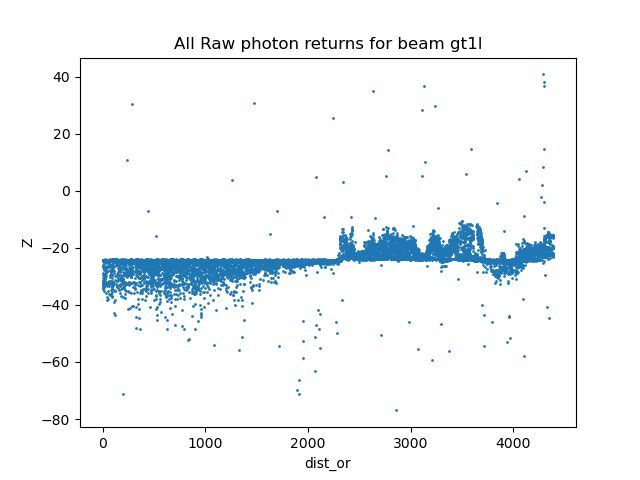

In [12]:
gdf.plot.scatter(x='dist_or',y='Z',s=1,title=f'All Raw photon returns for beam {beam}')

In [129]:
# geodf = atl03_utils.get_track_gdf(gt1l)
# gdf.to_file('../data/derived/testpoints3.gpkg')


In [19]:
round(len(gdf)/10000)

2

In [20]:
# we want chunks of about 10.000 returns
nchunks = max(round(len(gdf)/10000),1)
sndf = [] 

Ra = 1
# this loop splits the dataframe into chucks of approximately 
for chunk in np.array_split(gdf,nchunks):
    array = chunk.to_records()
    print(len(array))
    minpts = atl03_utils.min_dbscan_points(array,Ra)
    fitarray = np.stack([array["dist_or"], array["Z"]]).transpose()
    # for debugging
    print(f"{minpts=}")
    # run the clustering algo
    clustering = DBSCAN(eps=Ra, min_samples=minpts).fit(fitarray)

    # # move all the points and their labels into a dataframe
    df = pd.DataFrame(array).assign(cluster=clustering.labels_)
    # print(df)
    # df.cluster = df.cluster.astype("category")
    # print("Number of clusters", df.cluster.nunique())
    df["SN"] = df.cluster.apply(lambda x: "noise" if x == -1 else "signal")
    sndf.append(df)


9512
seglen=2243.355362762795,N1=9512,N2=4,h=101.87688255310059
minpts=3
9511
seglen=2147.026909145255,N1=9511,N2=1,h=117.71263885498047
minpts=3


<AxesSubplot:xlabel='dist_or', ylabel='Z'>

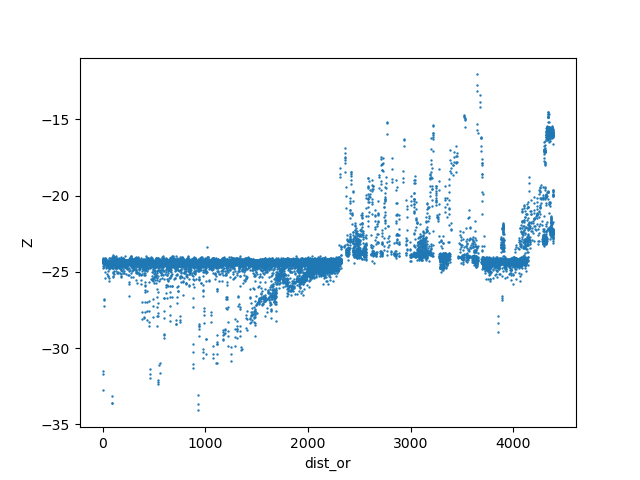

In [21]:
merged = pd.concat(sndf)

merged[merged.SN=='signal'].plot.scatter(x='dist_or',y='Z',s=0.5)


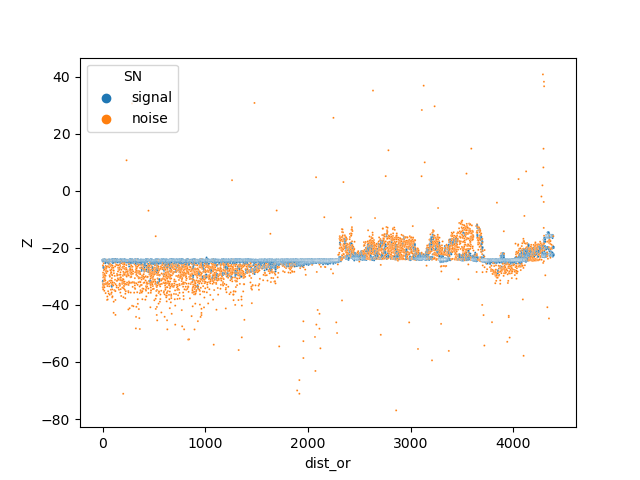

In [22]:
plt.clf()
plt.figure()
sns.scatterplot(data=merged,x="dist_or", y="Z",hue='SN',s=2)
plt.show()

## Bathymetric correction

Formula from Parrish et al.

### Seperating sea surface from seafloor
> The signal photons on sea surface and seafloor were detected using the above-mentioned method in last section. To obtain the precise water depth along ICESat-2's flight routes, the sea surface photons should be firstly discriminated against the seafloor photons. The local mean sea level Lm and the root mean square (RMS) wave height were calculated by the mean and standard deviation from the detected photons on the sea surface. All photons with the elevations lower than the local mean sea level minus 3-time RMS wave height were identified as seafloor photons.

